# Tools

In [1010]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import IsolationForest
from collections import Counter

In [1011]:
# InteractiveShell.ast_node_interactivity = "all"
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Configuration

In [1012]:
max_number_of_clusters = 10
min_number_of_clusters = 2

# todo
class OUTLIER_REMOVAL(Enum):
    NONE = 1 
    VARIANCE_THRESHOLD_WITHIN_CLUSTER = 2 
    ISOLATION_FOREST = 3 

outlier_removal = OUTLIER_REMOVAL.VARIANCE_THRESHOLD_WITHIN_CLUSTER.value

In [1013]:
number_of_addresses = 40000

# format: yyyy-mm-dd
observation_period_start = "2019-09-01 00:00:00+00"
observation_period_end = "2020-02-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random features.index, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.HIGHEST_TURNOVER.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset = False

# Create feature table in bigquery

In [1014]:
try:
    pm.execute_notebook(
       './bigquery/features.ipynb',
       './bigquery/build/features.build.ipynb',
       parameters = dict(number_of_addresses=number_of_addresses, observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset),
       cwd = "./bigquery"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise


Feature table does already exist.


# Load feature table from bigquery

In [1015]:
table_name = "features"
table_id = "{}_{}_{}_{}_{}".format(table_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

filename = '{}.json'.format(table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    features = query_job.result().to_dataframe(); 
    features = features.set_index("address")
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
        

Loading data from local cache ...
Time to retrieve data from local cache: 1 Seconds.


In [1016]:
m = features.memory_usage();
total_bytes = m.sum();
total_megabytes = total_bytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(total_megabytes)))

Size of the account feature dataset: 9.0 Megabytes.


In [1017]:
features.head()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,avg_usd_received,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used
0x000000000000541e251335090ac5b47176af4f7e,2617714724564890129037,2499440325886879608869,118274398678010520168,10499,10435,1169.736616,1172.564597,0,5807.198486,6648.193188,...,39.022867,4.99888e+20,5.23543e+20,7.827162e+04,8.194022e+04,2087.0,2099.8,672,13735,13
0x0000000000c90bc353314b6911180ed7e06019a9,23750592297109133527805,23415222312333022724096,335369984776110803709,104558,47941,126.398854,275.407843,0,733.979148,1669.440139,...,35.967030,4.68304e+21,4750118459421826705561,7.416413e+05,7.521281e+05,9588.2,20911.6,0,185542,61
0x00000000af5a61acaf76190794e3fdf1289288a1,79860483653126292524017,80200759289904168438234,-340275636777875914217,34890,43271,377.455186,304.345597,0,1813.135014,2315.587250,...,351.790254,1.60402e+22,1.59721e+22,2.468949e+06,2.454792e+06,8654.2,6978.0,9728,24655,68
0x00000000b1786c9698c160d78232c78d6f6474fe,717139468433019956699,609471395766503655298,107668072666516301401,501,4518,532.378000,58.897720,0,3871.881781,1317.759290,...,256.853910,609471395766503655298,717139468433019956699,1.093300e+05,1.286838e+05,4518.0,501.0,4192,4482,20
0x000000aaee6a496aaf7b7452518781786313400f,31961262806238051182749,31952412435011956257313,8850371226094925436,276,1372,39544.261818,8686.048140,0,93734.360666,42250.864110,...,20179.863524,6.39048e+21,6.39225e+21,1.112884e+06,1.113928e+06,274.4,55.2,0,1351,28


# Set avg_time_diff and stddev 0 values to max

In [1018]:
features["avg_time_diff_sent_tx"] = features["avg_time_diff_sent_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_sent_tx"]))
features["avg_time_diff_received_tx"] = features["avg_time_diff_received_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_received_tx"]))

In [1019]:
features["stddev_received_tx"] = features["stddev_received_tx"].replace(to_replace=0.0, value=max(features["stddev_received_tx"]))
features["stddev_sent_tx"] = features["stddev_sent_tx"].replace(to_replace=0.0, value=max(features["stddev_sent_tx"]))

# TMP

In [1020]:
features = features.drop(columns=["stddev_received_tx","stddev_sent_tx","avg_time_diff_sent_tx","avg_time_diff_received_tx"])

# Standardise feature values, so that all feature values have the same mean and stddev

In [1021]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns, index=features.index);

# Use Isolationforest to identify outliers

In [1022]:
clf = IsolationForest(max_samples="auto", behaviour='new', contamination='auto')

clf.fit(features_std)
pred = clf.predict(features_std)

features_clean = features[pred == 1]
features_std_clean = features_std[pred == 1]

outliers = features[pred == -1]

print("Number of detected outliers: {}".format(outliers.shape[0]))

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Number of detected outliers: 1988


In [1023]:
# Display outliers
outliers_tmp = outliers.copy()
outliers_tmp["turnover"] = outliers["wei_received"] + outliers["wei_sent"]
outliers_tmp = outliers_tmp.sort_values(by=["turnover"], ascending=False)
outliers_tmp.head()

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,mined_blocks,active_months,usd_received,usd_sent,avg_wei_sent,...,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,turnover
0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,11329252155535834171833497,11218404798936185645211577,110847356599648526621920,428837,314966,0,5,1.901778e+09,1.884193e+09,3.56178e+19,...,2.24368e+24,2.26585e+24,3.768385e+08,3.803555e+08,62993.20,85767.40,0,225013,127,22547656954472019817045074
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,6736326237841738290677133,5706510426813962971936808,1029815811027775318740325,2579724,377228,0,5,1.069384e+09,9.042215e+08,1.51275e+19,...,1.1413e+24,1.34727e+24,1.808443e+08,2.138769e+08,75445.60,515944.80,0,0,0,12442836664655701262613941
0xa7efae728d2936e78bda97dc267687568dd593f3,4007359259697374000000000,3792572311000000000000000,214786948697374000000000,88853,43717,0,4,6.443581e+08,6.084651e+08,8.67528e+19,...,948143077750000000000000,1001839814924343500000000,1.521163e+08,1.610895e+08,10929.25,22213.25,0,0,0,7799931570697374000000000
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,2728917736118778625468861,2817659185849405400000000,-88741449730626774531139,110388,54919,0,5,4.490359e+08,4.680559e+08,5.13057e+19,...,563531837169881080000000,5.45784e+23,9.361118e+07,8.980717e+07,10983.80,22077.60,0,0,0,5546576921968184025468861
0xfa52274dd61e1643d2205169732f29114bc240b3,2728915396568188709223010,2728915396568188709223010,0,110377,110377,0,5,4.490356e+08,4.490356e+08,2.47236e+19,...,545783079313637741844602,545783079313637741844602,8.980711e+07,8.980711e+07,22075.40,22075.40,0,0,0,5457830793136377418446020


In [1024]:
# # opens outliers features.index via etherscan
# n = 5 # first n features.index get opened
# i = 0
# for address, features in outliers_tmp.iterrows():
#     webbrowser.open('https://etherscan.io/address/{}'.format(address), new=2)
#     i += 1
#     if i == n:
#         break

# Use Isolationforest to remove outliers

In [1025]:
if outlier_removal == OUTLIER_REMOVAL.ISOLATION_FOREST.value:
    features = features_clean
    features_std = features_std_clean

# Dimension Reduction via Principal Component Analysis

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [1026]:
min_explained_variance = 0.9

In [1027]:
pca = PCA().fit(features_std)
optimal_number_of_clusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimal_number_of_clusters = optimal_number_of_clusters + 1
    if i > min_explained_variance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimal_number_of_clusters, min_explained_variance*100))

Die 8 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.


<Figure size 720x360 with 0 Axes>

<BarContainer object of 22 artists>

Text(0.5, 0, 'Number of Components')

Text(0, 0.5, 'Variance (%)')

Text(0.5, 1.0, 'PCA: Explained Variance')

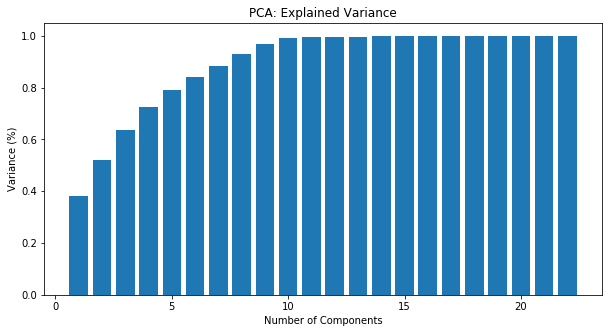

In [1028]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()

In [1029]:
pca = PCA(n_components=optimal_number_of_clusters);
features_std_pca = pca.fit_transform(features_std);
features_std_pca = pd.DataFrame(features_std_pca);
features_std_pca.index = features.index
features_std_pca.head()

,0,1,2,3,4,5,6,7
0x000000000000541e251335090ac5b47176af4f7e,0.110654,0.663547,-0.426214,-0.083189,0.818502,1.367920,0.288124,-0.268395
0x0000000000c90bc353314b6911180ed7e06019a9,3.146615,4.999051,-0.805675,0.650590,6.612558,2.205577,0.000383,-2.580727
0x00000000af5a61acaf76190794e3fdf1289288a1,3.107312,1.826726,-0.767117,-0.144162,3.326877,4.725837,-1.932856,2.474221
0x00000000b1786c9698c160d78232c78d6f6474fe,-0.113051,0.404326,-0.092491,-0.002373,0.598290,0.667893,-1.367968,1.612411
0x000000aaee6a496aaf7b7452518781786313400f,0.791430,0.042167,-0.484686,-0.268543,0.124105,2.120692,0.530397,-0.380242


# Caluclate number of clusters via Clinski Harabasz Score

In [1030]:
def estimateNumberOfClusters(features, features_std_pca, max_number_of_clusters):
    scores = []
    numberOfCluster = []

    for i in range(2,max_number_of_clusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimal_number_of_clusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimal_number_of_clusters;

In [1031]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [1032]:
scores = []
numberOfCluster = []

# 3 clusters are not considered to be valid
for i in range(min_number_of_clusters, max_number_of_clusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(features_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimal_number_of_clusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'number_of_clusters')

Text(0, 0.5, 'calinski_score')

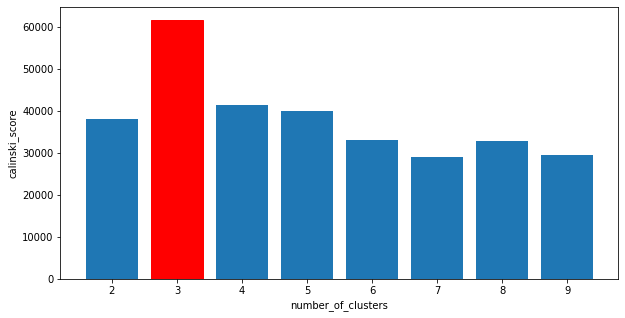

The optimal number of clusters is 3.


In [1033]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimal_number_of_clusters))

In [1034]:
#  optimal_number_of_clusters = 5 # tmp

# Clustering

In [1035]:
kmeans_opt = KMeans(n_clusters=optimal_number_of_clusters)
kmeans_opt.fit(features_std_pca)

features["label"] = kmeans_opt.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Remove outliers for each cluster via variance threshold

In [1036]:
# assumes that the index of dataframe features consists of the addresses
def remove_outliers(features, kmeans, threshold):
    
    features_without_outliers = pd.DataFrame()
    labels_without_outliers = []

    for label, centroid in enumerate(kmeans.cluster_centers_):
        
        features_within_cluster = features[kmeans_opt.labels_ == label];
        # distance of each point in cluster to cluster's centroid
        distances = features_within_cluster - centroid;
        # convert to scalar
        distances_norm = np.linalg.norm(distances, axis=1);
        # max_distance for this cluster
        max_distance = threshold * np.linalg.norm(features_within_cluster.std())
        
        keep = distances_norm <= max_distance
        
        features_without_outliers = features_without_outliers.append(features_within_cluster[keep])
        labels_without_outliers.extend([label for i in features_within_cluster[keep].iterrows()])
        
    features_without_outliers["label"] = labels_without_outliers
    return features_without_outliers

In [1037]:
# def remove_outliers(features, features_std_pca, kmeans, threshold):
    
#     features_std_pca_within_cluster_new = pd.DataFrame();
#     features_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         features_std_pca_within_cluster = features_std_pca[kmeans_opt.labels_ == clusterNumber];
#         features_within_cluster = features[kmeans_opt.labels_ == clusterNumber];
            
#         distances = features_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(features_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         features_std_pca_within_cluster_new = features_std_pca_within_cluster_new.append(features_std_pca_within_cluster[keep])
#         features_within_cluster_new = features_within_cluster_new.append(features_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in features_within_cluster[keep].iterrows()])
        
#     return features_std_pca_within_cluster_new, features_within_cluster_new, labels_new

In [1038]:
from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 10)
thresholds = np.linspace(.0001,.6, 20)

features_tables_without_outliers = [remove_outliers(features_std_pca, kmeans_opt, t) for t in thresholds]

# scores= []

# for (features, labels) in test:
#     features.head()
#     len(labels)
#     len(features)
#     if not features.empty and len(np.unique(np.array(labels))) > 1:
#         scores.append(metrics.calinski_harabasz_score(features, labels)) 

In [1039]:
scores= []
res = []

for f,t in zip(features_tables_without_outliers, thresholds):
    if not features.empty and len(f["label"].unique()) > 1:
        scores.append((metrics.calinski_harabasz_score(f.drop(columns=["label"]), f["label"]), t))
        res.append(f)
        
scores = [x for x in zip(*scores)]

Text(0.5, 1.0, 'Calinski Harabaz Scores as std threshold changes')

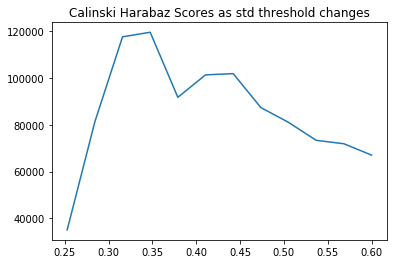

In [1040]:
plt.plot(scores[1], scores[0])
plt.title('Calinski Harabaz Scores as std threshold changes')

In [1041]:
optimal_threshold = thresholds[np.argmax(scores)]
print("The threshold leading to the highest Calinski Harabaz Score is", optimal_threshold)

The threshold leading to the highest Calinski Harabaz Score is 0.09482105263157896


In [1042]:
features_std_pca_without_outliers = res[np.argmax(scores)]
# features_std_pca = pd.DataFrame(features_std_pca)
# features = pd.DataFrame(features)

In [1044]:
# features_std_pca_without_outliers.head()
if outlier_removal == OUTLIER_REMOVAL.VARIANCE_THRESHOLD_WITHIN_CLUSTER.value:
    features = features.reindex(features_std_pca_without_outliers.index)
    features_std = features_std.reindex(features_std_pca_without_outliers.index)
    features_std_pca = features_std_pca.reindex(features_std_pca_without_outliers.index)

# Visualisierung: T-SNE

In [1045]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# features_std_pca_out_tsne = tsne.fit_transform(features_std_pca_out)
# features_std_pca_out_tsne = pd.DataFrame(features_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# features_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [1046]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# features_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# features_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=features_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

# Cluster data

In [1047]:
clusters = dict() 
labels = features["label"].unique()
labels.sort()

for label in labels:
    cluster_name = 'cluster_{}'.format(label)
    
    features_in_cluster = features[features.label == label]
    
    clusters[cluster_name] = dict()
    clusters[cluster_name]["number_of_addresses"] = Counter(features["label"])[label]
    clusters[cluster_name]["feature_means"] = features_in_cluster.drop(columns=["label"]).mean()
    
feature_means = pd.DataFrame(columns = clusters[cluster_name]['feature_means'].keys())

for key in clusters:
    clusters[key]["feature_means"].name = key
    feature_means = feature_means.append(clusters[key]["feature_means"])

## Display principal components

Text(0.5, 0.92, 'First three PCA Components')

Text(0.5, 0, '1st eigenvector')

[]

Text(0.5, 0, '2nd eigenvector')

[]

Text(0.5, 0, '3rd eigenvector')

[]

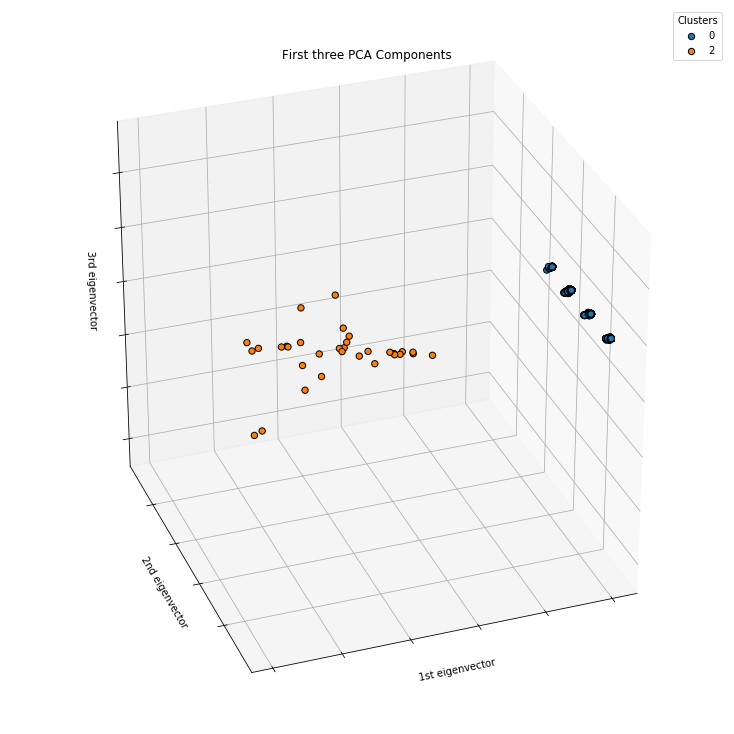

In [1048]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
features_std_pca_tmp["label"] = features["label"]

labels = np.sort(features_std_pca_tmp.label.unique())

for l in labels:
    ax.scatter(features_std_pca_tmp["1st eigenvector"][features_std_pca_tmp["label"] == l], 
           features_std_pca_tmp["2st eigenvector"][features_std_pca_tmp["label"] == l],
           features_std_pca_tmp["3st eigenvector"][features_std_pca_tmp["label"] == l],
           label = l, 
           edgecolor='k', s=40, alpha = 1);

ax.set_title("First three PCA Components");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);
ax.legend(title= "Clusters")

# Display cluster means 

In [1049]:
feature_means_display = feature_means.round()

feature_means_display["eth_received"] = feature_means_display["wei_received"] / 10**18
feature_means_display["eth_sent"] = feature_means_display["wei_sent"] / 10**18
feature_means_display["eth_balance"] = feature_means_display["balance"] / 10**18
feature_means_display["avg_eth_sent"] = feature_means_display["avg_wei_sent"] / 10**18
feature_means_display["avg_eth_received"] = feature_means_display["avg_wei_received"] / 10**18
feature_means_display["monthly_eth_sent"] = feature_means_display["monthly_wei_sent"] / 10**18
feature_means_display["monthly_eth_received"] = feature_means_display["monthly_wei_received"] / 10**18

feature_means_display = feature_means_display.drop(columns=["wei_received"])
feature_means_display = feature_means_display.drop(columns=["wei_sent"])
feature_means_display = feature_means_display.drop(columns=["balance"])
feature_means_display = feature_means_display.drop(columns=["avg_wei_sent"])
feature_means_display = feature_means_display.drop(columns=["avg_wei_received"])
feature_means_display = feature_means_display.drop(columns=["monthly_wei_sent"])
feature_means_display = feature_means_display.drop(columns=["monthly_wei_received"])

feature_means_display["number_of_addresses"] = [clusters[c]["number_of_addresses"] for c in clusters]

cols = list(feature_means_display.columns.values) 
cols.pop(cols.index('number_of_addresses')) 
cols.pop(cols.index('eth_balance')) 
cols.pop(cols.index('eth_sent')) 
cols.pop(cols.index('eth_received')) 
feature_means_display = feature_means_display[["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]+cols] 


if len(feature_means_display.columns) > len(feature_means_display.index):
    print("Number of Addresses: {}".format(number_of_addresses))
    print("Observation-Period: {} to {}".format(observation_period_start, observation_period_end))
    display(feature_means_display.T.astype("int"))
else:
    display(feature_means_display.astype("int"))

'number_of_addresses'

'eth_balance'

'eth_sent'

'eth_received'

Number of Addresses: 40000
Observation-Period: 2019-09-01 00:00:00+00 to 2020-02-01 00:00:00+00


,cluster_0,cluster_2
number_of_addresses,15952,32
eth_balance,-8,-9506
eth_sent,1268,1075274
eth_received,1259,1065768
number_of_tx_received,68,26104
number_of_tx_sent,138,29758
mined_blocks,0,0
active_months,3,4
usd_received,209648,179541240
usd_sent,211034,180864444


In [1050]:
# fig, ax = plt.subplots(figsize= (20,10))

# scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
# features_std = scaler.fit_transform(features);
# features_std = pd.DataFrame(features_std, columns=features.columns);
# X_reduced = PCA(n_components=2).fit_transform(features_std);

# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_opt.labels_)
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")
# pd.Series(kmeans_opt.labels_).unique()

In [1051]:
# features_std_pca_tmp.idxmax()

In [1052]:
# snowflakes = features_std_pca_tmp.idxmax()
# snowflakes
# for i in snowflakes:
#     print(features.index[i])

# Display Cluster means with standardised features via radar plots

In [1053]:
# cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
# cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
# cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# # cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

# ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

# ax.tick_params(
#     which="major",
#     axis='x', 
#     bottom=False
#     )

# ax.tick_params(
#     which="major",
#     axis='y', 
#     labelsize=15
#     ) 

# ylabels = ax.get_yticklabels()

# ax.legend(loc="lower right", fontsize="larger")

# ax.set_xticklabels([])
# ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

([<matplotlib.projections.polar.ThetaTick at 0x7f6362686048>,
 <a list of 22 Text xticklabel objects>)

Text(0.5, 1.05, '(cluster_0, addresses: 15952)')

([<matplotlib.projections.polar.ThetaTick at 0x7f6362662048>,
 <a list of 22 Text xticklabel objects>)

Text(0.5, 1.05, '(cluster_2, addresses: 32)')

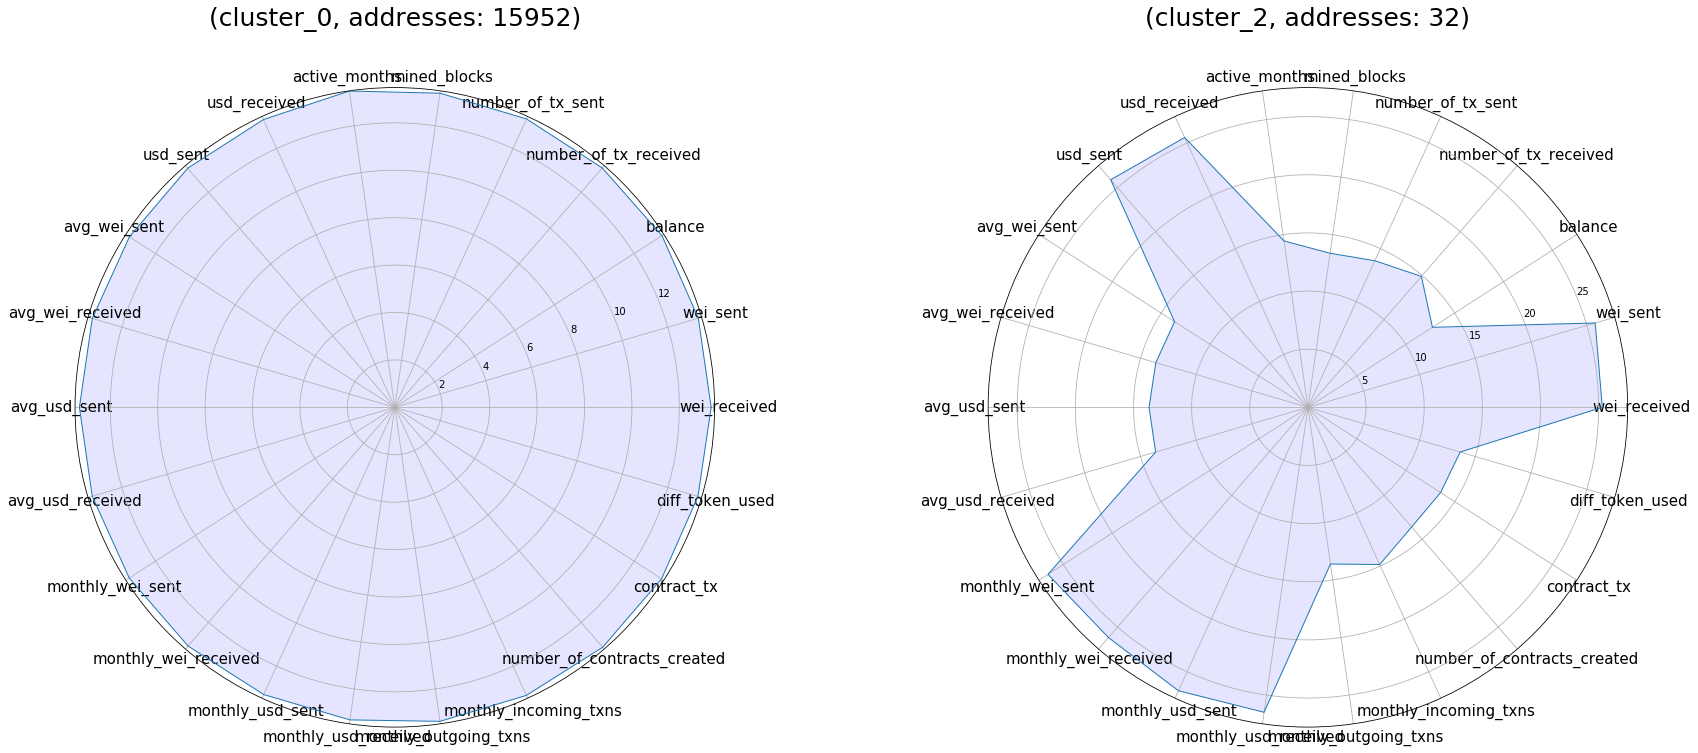

In [1054]:
from math import pi
N = len(feature_means.columns)

values = {}
feature_std_means = pd.DataFrame(columns=features.columns[:-1])

for label in labels:
    features_in_cluster = features_std[features["label"] == label]
    feature_means_tmp = features_in_cluster.mean()
    feature_means_tmp.name = 'cluster_{}'.format(label)
    feature_std_means = feature_std_means.append(feature_means_tmp)

# make all values positive, otherwise bigger values are displayed as if they were smaller 
feature_std_means_positive = feature_std_means + feature_std_means.max().max()

for i,v in feature_std_means.iterrows(): 
    tmp_values = feature_std_means_positive.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values[i] = tmp_values
    
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(30,40))

i = 1

for cluster_name, cluster_values in values.items():
    position = int("".join([str(32), str(i)]))
    i += 1
    axis = plt.subplot(position, polar=True)
    plt.sca(axis)
    
    plt.xticks(angles[:-1], features.columns, size=15)
    
    axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
    axis.fill(angles, cluster_values, 'b', alpha=0.1)
    axis.set_title("({}, addresses: {})".format(cluster_name, clusters[cluster_name]["number_of_addresses"]), color = "black", size=25, loc="center", pad=30)
#     plt.yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0], size=25, c="red")
    

In [1055]:
# from math import pi

# cluster_data_for_plot2 = cluster_data_for_plot1.copy()
# cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
# cluster_data_for_plot2 = cluster_data_for_plot2.sort_index()
# # cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

# categories=list(cluster_data_for_plot2)
# N = len(categories)

# values = {}

# for i,v in cluster_data_for_plot2.iterrows(): 
#     tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
#     tmp_values += tmp_values[:1]
#     values[i] = tmp_values

# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
# angles
 
# plt.figure(figsize=(30,40))

# for cluster_label, cluster_values in values.items():
#     position = int("".join([str(33), str(cluster_label + 1)]))
#     axis = plt.subplot(position, polar=True)
#     plt.sca(axis)
#     plt.xticks(angles[:-1], categories, size=15)

# #     plt.ylim(top=1)

#     axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
#     axis.fill(angles, cluster_values, 'b', alpha=0.1)
# #     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
#     axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)
#     axis.set_yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0])

In [1056]:
# yticks = axis.get_yticks()
# print(yticks)
# newyticks = [t for i,t in enumerate(yticks) if i%2==0]
# newyticks
# # axis.set_yticks()

In [1057]:
# for i,cd in cluster_data.iterrows():a
#     x = features.index[kmeans_opt.labels_==i]
#     print("Length of cluster with id={}: {}".format(i, len(x)))
#     display(x)
#     print("############################")

# Clustering Evaluation: Recall, Precision and F1 score 

Get addresses with labels from etherscan

In [1058]:
import csv

addresses_with_es_labels = dict()

files = os.listdir("./data")
relevant_files = [f for f in files if "labelcloud" in f]

for f in relevant_files:
    with open("./data/{}".format(f), newline="") as csvFile:
        reader = csv.reader(csvFile, delimiter=",")       
        addresses_with_es_labels[f.split("_",1)[0]]  = [row[0] for row in reader if len(row) > 0]

In [1059]:
etherscan_labels = pd.DataFrame()
es_label = 'exchanges'

for addr in list(features.index):
    if addr.lower() in addresses_with_es_labels[es_label]:
        etherscan_labels = etherscan_labels.append(pd.Series(1, name=addr))

etherscan_labels.columns = [es_label]    
etherscan_labels = etherscan_labels.reindex(index=features.index)
etherscan_labels = etherscan_labels.fillna(0)
etherscan_labels[es_label] = etherscan_labels[es_label].astype("int")

features["es_label_{}".format(es_label)] = etherscan_labels[es_label]
features.head()  

cluster_list = []

for label in features.label.unique():
    cluster_list.append(features[features["label"] == label]["es_label_{}".format(es_label)])

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,mined_blocks,active_months,usd_received,usd_sent,avg_wei_sent,...,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,label,es_label_exchanges
0x00009bcabff192283a764d2b001b241d2c55d81b,469020000000000000000,469018320000000000000,1680000000000000,5,4,0,3,73262.478400,73262.188768,117254580000000000000,...,156340000000000000000,24420.729589,24420.826133,1.333333,1.666667,0,0,0,0,0
0x0001485a7b71a82b60cce53fa44a1d223f4edc02,608936000000000000000,615407200000000000000,-6471200000000000000,6,318,0,4,94222.489030,85070.287437,1.93524e+18,...,152234000000000000000,21267.571859,23555.622257,79.500000,1.500000,0,156,1,0,0
0x0004eef7c483f227b3f5f75d28f3ef8c85d85319,3209396762591348500000,2989453203000000000000,219943559591348500000,634,206,0,2,460027.162951,427202.589654,1.45119e+19,...,1604698381295674250000,213601.294827,230013.581476,103.000000,317.000000,0,6,1,0,0
0x0005978d7593c7b8ff2d860091a2d25056349e35,468916507642677853633,477829215974561735861,-8912708331883882228,69,44,0,2,89562.587251,90493.359657,1.08598e+19,...,2.34458e+20,45246.679829,44781.293626,22.000000,34.500000,0,0,0,0,0
0x0005d883fc1dc3e91b8905543063d47a43708182,308332561680000000000,308269991160000000000,62570520000000000,49,49,0,2,51534.218756,51522.223135,6.29122e+18,...,154166280840000000000,25761.111568,25767.109378,24.500000,24.500000,0,28,5,0,0


In [1060]:
import collections as collections
from math import factorial as fac

def b(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

Counter = collections.Counter

num_doc= 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []

# Calculate True Positives

for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    c = Counter(cluster_list[c])
    c_list.append(c)
    TP += b(c[1], 2) 

# Calculate False Positives
    
for c in range(0, len(cluster_list)): 
    c = Counter(cluster_list[c])
    FP += c[1] * c[0]

# Add all the cluster together

sum = Counter()
for c in c_list:
    sum += c

# Calculating False Negatives

for ct in c_list:
    fn_temp = 0 

    fn_temp += ct[1]*(sum[1]-ct[1])
    sum -= ct
    FN += fn_temp

print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)

Precision = TP/(TP+FP)
print("Precision is %.4f " % Precision)

Recall = TP/(TP+FN)
print("Recall is %.4f " % Recall)

F1=(2*Recall*Precision)/(Recall+Precision)
print("F1 is %.4f " % F1)

TP is 72 
FP is 64032 
FN is 48 
Precision is 0.0011 
Recall is 0.6000 
F1 is 0.0022 


# Helper functions to analyse data

In [1075]:
i = 0
for index, row in features[features.label == 2].iterrows():
    i += 1
    a = row.name
    webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    if i == 5:
        break

True

True

True

True

True

In [1062]:
# def open_etherscan(cluster_id, number_of_addresses):
#     if len(features.index[features.label==cluster_id]) > number_of_addresses:
#         for a in np.random.choice(features.index[kmeans_opt.labels_==cluster_id], number_of_addresses):
#             webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
#     else:
#         for a in features.index[features.label==cluster_id]:
#             webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    
# open_etherscan(1, 3)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15984 but corresponding boolean dimension is 40000

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

In [ ]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3",
          "Cookie": "_ga=GA1.2.501875784.1580321678; etherscan_cookieconsent=True; __cfduid=d361eede6a818d85e197685c3b1fca6911585732139; ASP.NET_SessionId=ac5xtlkyswxx0jxagox3bc2d; _gid=GA1.2.644739241.1586167885"}
reg_url = "https://etherscan.io/accounts/label/exchange/1?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [ ]:
res1 = re.findall("address/0x.{40}", html)
res1 = re.findall("0x.{40}", str(res1))

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
elements = soup.find_all("tr")
elements = list(elements)[1:-1]
exchangeNames = [e.contents[1].get_text() for e in elements]
exchangeAddresses = [e.contents[0].get_text().strip(" ") for e in elements]
display(len(exchangeNames))
display(len(exchangeAddresses))
# for i in e:
#     print(i.contents[1].get_text())
#     print(i.children[1])

In [ ]:
# exchanges = [(a, "e") for i, a in enumerate(features.index) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(features.index) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # features.index[kmeans_opt.labels_ == 2]

# tmp = pd.DataFrame(zip(features.index, kmeans_opt.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of features.index", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
import collections as collections

Counter = collections.Counter

cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
num_doc= 0
positives = 0
negatives = 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []
for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    # calculating positives...
    positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

    # calculating TP...
    c = Counter(cluster_list[c])
    c_list.append(c)
    tp_temp = 0 
    for k,v in dict(c).items():
        if v>1:
            tp_temp += (v*(v-1))/2
    TP += tp_temp 

FP = positives - TP
negatives = ((num_doc*(num_doc-1))/2) - positives
# Add all the cluster together
sum = Counter()

for c in c_list:
    sum += c

# calculating FN...
for ct in c_list:
    fn_temp = 0 
    for k,v in dict(ct).items():
        fn_temp += v*(sum[k]-v)
    sum -= ct
    FN += fn_temp
TN = negatives -FN
print("num_doc is %d " % num_doc)
print("positives is %d " % positives)
print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)
print("TN is %d " % TN)

Precision = TP/(TP+FP)
print("Precision is %.2f " % Precision)

Recall = TP/(TP+FN)
print("Recall is %.2f " % Recall)

F1=(2*Recall*Precision)/(Recall+Precision)
print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)